# Paper figures: spectral analysis and sanity checks

This notebook creates all figures of the first part of the paper: sanity checks and time-frequency analysis at word event to check for consistent power modulation and phase clustering at word onsets.

In [1]:
import os
import warnings
warnings.filterwarnings('ignore', message='distutils')
warnings.filterwarnings('ignore', message='nyq', module='scipy')
warnings.filterwarnings('ignore', message='nyq', module='mne')
import mne
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyeeg.vizu import topomap
from audiobook.utils import extract_story_parts_data, read_hdf_raws
from audiobook.features import get_feature_signal
from audiobook import subjects, STORIES, DATA_PATH
from scipy.signal import hilbert, welch

from tqdm.notebook import tqdm

dataset_path = '/project/3027007.01/analysis/Hugo/Data/raws.h5'

In [2]:
import fooof
from scipy.signal import welch

In [3]:
from sklearn.cluster import KMeans

def find_bad_components(ica, x, typical_freqs=(20, 40, 80), thresh=0.5):
    """
    Detects which components might carry the artefactual peaks at given frequencies.
    
    Params
    ------
    ica : inst of ICA
    x : inst of Raw
    """
    fmin = np.min(typical_freqs) - 2
    fmax = np.max(typical_freqs) + 4
    comps = ica.get_sources(x)
    psds, freqs = mne.time_frequency.psd_welch(comps, picks=comps.ch_names, verbose=False)
    del comps
    comparing = psds[:, (freqs>fmin)] -  1.3*np.median(psds[:, (freqs>fmin) & (freqs<fmax)], axis=1, keepdims=True)
    chans, freq_above_idx = np.argwhere(comparing > 0).T
    freq_above = freqs[np.argmax(freqs>fmin) + freq_above_idx]
    comps = []
    for c in tqdm(np.unique(chans), leave=False):
        if len(freq_above[chans==c]) < 3 : continue
        km = KMeans(n_clusters=3)
        km.fit(freq_above[chans==c].reshape(-1, 1), sample_weight=comparing[c][np.unique(freq_above_idx[chans==c])])
        if sum([np.abs(kc - f) < thresh for kc,f in  zip(sorted(km.cluster_centers_), sorted(typical_freqs))]) >= 2: # at least two matching groups of freqs
            comps.append(c)
    if len(comps) > 0:
        print(f"Components suggested for removal: {comps}")
        return comps
    else:
        print("Did not find any problematic component.")

In [4]:
subject = np.random.choice(subjects)
subject = subject[:3] +'-'+ subject[3:]
print(f'Subject: {subject}')

Subject: sub-020


In [5]:
phase = read_hdf_raws(subject, STORIES.filename.str.strip('.wav')[0], srate=50, fband='delta')
amp = read_hdf_raws(subject, STORIES.filename.str.strip('.wav')[0], srate=50, fband='beta')

info = mne.io.read_info(os.path.join(DATA_PATH, 'processed', subject, 'meg', 'audioBook-filtered-ICAed-raw.fif'))
bads = ['MLT41', 'MRO52']
info = mne.pick_info(info, sel=mne.pick_types(info, meg=True, ref_meg=False, exclude=bads))

    Read 5 compensation matrices
Removing 5 compensators from info because not all compensation channels were picked.


In [7]:
# Try ica first
try:
    ica = mne.preprocessing.read_ica(f'/project/3027007.01/processed/{subject}/meg/audioBook-ica.fif')
    print("Loading data...")
    raws = extract_story_parts_data(subject, filter=None, ica=True)
    print("Dataloading done.")
    bad_comp = find_bad_components(ica, raws[0])
    for k, r in enumerate(raws):
        r.pick_types(meg=True, ref_meg=False)
        r.filter(0.5, 82)
        if bad_comp is not None:
            raws[k] = ica.apply(r.copy(), exclude=bad_comp, verbose=False)
except Exception as e:
    print(e.message)

  0%|          | 0/54 [00:00<?, ?it/s]

In [20]:
X = get_feature_signal(feats=['wordonsets'], srate=100)

Load stimulus features
Loading feature signal for : ['wordonsets']
Done. X shape: (29800, 1)


In [21]:
events = mne.event.find_events(mne.io.RawArray(X[0].T, mne.create_info(['onset'], 100, ch_types='stim')).resample(200))
eventid = {'Word onset': events[0, 2]}
events[:, 0] += raws[0].first_samp

epochs = mne.Epochs(raws[0], events, eventid, tmin=-0.4, tmax=1.0, baseline=None, preload=True)

Creating RawArray with float64 data, n_channels=1, n_times=29800
    Range : 0 ... 29799 =      0.000 ...   297.990 secs
Ready.
938 events found
Event IDs: [5]
938 events found
Event IDs: [5]
938 events found
Event IDs: [5]
Not setting metadata
Not setting metadata
938 matching events found
No baseline correction applied
0 projection items activated
Loading data for 938 events and 281 original time points ...
2 bad epochs dropped


/scratch/hugwei/49504642.dccn-l029.dccn.nl/ipykernel_15822/3910981052.py:2: RuntimeWarning: Estimated head size (567.9 mm) exceeded 99th percentile for adult head size
  fig = erp.plot(gfp=True, show=False);
/scratch/hugwei/49504642.dccn-l029.dccn.nl/ipykernel_15822/3910981052.py:2: RuntimeWarning: (X, Y) fit (-104.2, 155.2) more than 20 mm from head frame origin
  fig = erp.plot(gfp=True, show=False);


Text(0.5, 1.0, 'Word-ERP')

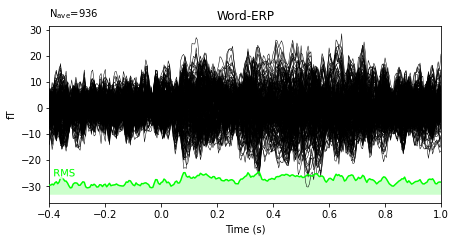

In [38]:
erp = epochs.average()
fig = erp.plot(gfp=True, show=False);
fig.axes[0].set_title('Word-ERP')

In [44]:
induced_epochs = epochs.copy()
induced_epochs._data = (epochs._data -  erp.data)

## Reproducing time-frequency analysis

I observed with the following code comparison that power induced is basically the same as total power (so most of it is induced)

```python
freqs = np.logspace(*np.log10([3, 80]), 32)
ncycles = np.linspace(2, 7, 32)
power, itc = mne.time_frequency.tfr_morlet(epochs[:500], freqs, ncycles, True, return_itc=True, n_jobs=1, average=True)
power_induced = mne.time_frequency.tfr_morlet(induced_epochs[:500], freqs, ncycles, True, n_jobs=1, average=True, return_itc=False)
# By "hand"
fourier = mne.time_frequency.tfr_morlet(epochs[:500], freqs, ncycles, True, return_itc=False, n_jobs=1, average=False, output='complex')
# abs first -> mean over epochs
avg = fourier.average(lambda x: np.mean(np.abs(x), 0)) # this is solely to create a AverageTFR object
avg.plot_joint(baseline=(-0.35, 0.), mode='zscore', tmin=-0.3, tmax=0.8, title='Induced power change');
# Evoked power: mean first (on complex fourier) -> then abs()
evok = fourier.average(lambda x: np.abs(x.mean(0)))
evok.plot_joint(baseline=(-0.35, 0.), mode='zscore', tmin=-0.3, tmax=0.8, title='Evoked power change');
# ITC
itc = fourier.average(lambda x: np.abs(np.mean(x/np.abs(x), 0)))
itc.plot_joint(baseline=(-0.35, 0.), mode='zscore', tmin=-0.3, tmax=0.8, title='ITPC');
```

In [ ]:
freqs = np.logspace(*np.log10([3, 80]), 32)
ncycles = np.linspace(2, 7, 32)
power, itc = mne.time_frequency.tfr_morlet(epochs[:500], freqs, ncycles, True, return_itc=True, n_jobs=1, average=True)

In [49]:
power_induced = mne.time_frequency.tfr_morlet(induced_epochs[:500], freqs, ncycles, True, n_jobs=1, average=True, return_itc=False)

/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


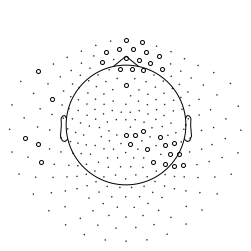

In [139]:
picks_theta = np.argsort(itc._data[:, (itc.freqs > 7) & (itc.freqs < 8.5)][..., (itc.times > 0.2) & (itc.times < 0.4)].mean(-1).mean(-1))[::-1][:35]

f, ax = plt.subplots(1, 1)
mne.viz.plot_topomap(np.zeros((269,)), itc.info, show=False, axes=ax, cmap=sns.blend_palette(['w', 'w'], as_cmap=True), mask=np.asarray([c in picks_theta for c in range(269)]))
f.set_facecolor('w')

No baseline correction applied
No baseline correction applied


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


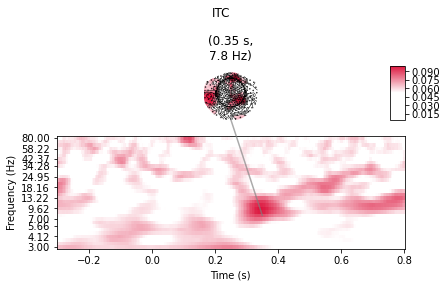

In [140]:
cmap = sns.blend_palette(['w', 'w', 'crimson'], as_cmap=True) # or inferno
itc.plot_joint(timefreqs=((0.35, 7.5)), baseline=None, mode='zscore', tmin=-0.3, tmax=0.8, title='ITC', cmap=cmap, vmin=0.015, vmax=0.06, topomap_args={'vmin':0.005, 'vmax':0.1, 'sphere':0.1});

Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)


/scratch/hugwei/49504642.dccn-l029.dccn.nl/ipykernel_15822/3994543909.py:1: RuntimeWarning: Estimated head size (567.9 mm) exceeded 99th percentile for adult head size
  power_induced.plot_joint(baseline=(-0.35, 0.), mode='zscore', tmin=-0.3, tmax=0.8, title='power induced');
/scratch/hugwei/49504642.dccn-l029.dccn.nl/ipykernel_15822/3994543909.py:1: RuntimeWarning: (X, Y) fit (-104.2, 155.2) more than 20 mm from head frame origin
  power_induced.plot_joint(baseline=(-0.35, 0.), mode='zscore', tmin=-0.3, tmax=0.8, title='power induced');
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__versio

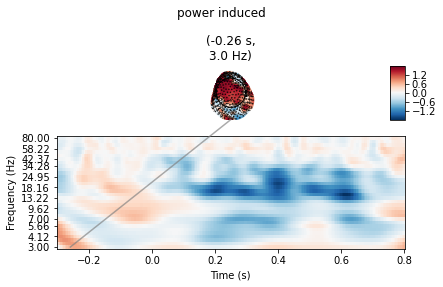

Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)


/scratch/hugwei/49504642.dccn-l029.dccn.nl/ipykernel_15822/3994543909.py:2: RuntimeWarning: Estimated head size (567.9 mm) exceeded 99th percentile for adult head size
  power.plot_joint(baseline=(-0.35, 0.), mode='zscore', tmin=-0.3, tmax=0.8, title='power');
/scratch/hugwei/49504642.dccn-l029.dccn.nl/ipykernel_15822/3994543909.py:2: RuntimeWarning: (X, Y) fit (-104.2, 155.2) more than 20 mm from head frame origin
  power.plot_joint(baseline=(-0.35, 0.), mode='zscore', tmin=-0.3, tmax=0.8, title='power');
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version)

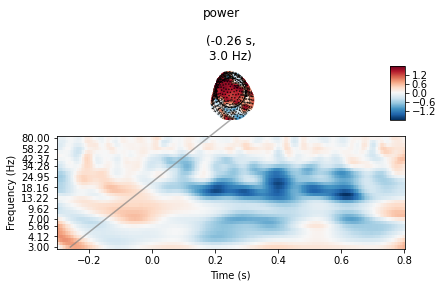

Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)


/scratch/hugwei/49504642.dccn-l029.dccn.nl/ipykernel_15822/3994543909.py:3: RuntimeWarning: Estimated head size (567.9 mm) exceeded 99th percentile for adult head size
  itc.plot_joint(baseline=(-0.35, 0.), mode='zscore', tmin=-0.3, tmax=0.8, title='ITC');
/scratch/hugwei/49504642.dccn-l029.dccn.nl/ipykernel_15822/3994543909.py:3: RuntimeWarning: (X, Y) fit (-104.2, 155.2) more than 20 mm from head frame origin
  itc.plot_joint(baseline=(-0.35, 0.), mode='zscore', tmin=-0.3, tmax=0.8, title='ITC');
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


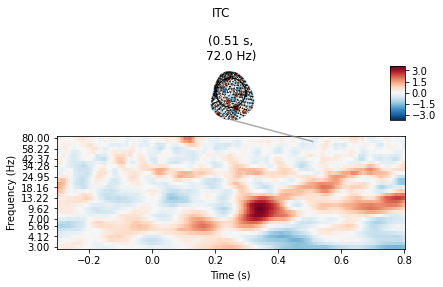

In [50]:
power_induced.plot_joint(baseline=(-0.35, 0.), mode='zscore', tmin=-0.3, tmax=0.8, title='power induced');
power.plot_joint(baseline=(-0.35, 0.), mode='zscore', tmin=-0.3, tmax=0.8, title='power');
itc.plot_joint(baseline=(-0.35, 0.), mode='zscore', tmin=-0.3, tmax=0.8, title='ITC');

By hand from the complex fourier coefficients.

In [22]:
freqs = np.logspace(*np.log10([3, 80]), 32)
ncycles = np.linspace(2, 7, 32)
# Takes a ~10 GB of space and a couple of minutes of processing!!
fourier = mne.time_frequency.tfr_morlet(epochs[:500], freqs, ncycles, True, return_itc=False, n_jobs=1, average=False, output='complex')

Not setting metadata


Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)


/scratch/hugwei/49504642.dccn-l029.dccn.nl/ipykernel_15822/1983313533.py:4: RuntimeWarning: Estimated head size (567.9 mm) exceeded 99th percentile for adult head size
  avg.plot_joint(baseline=(-0.35, 0.), mode='zscore', tmin=-0.3, tmax=0.8, title='Induced power change');
/scratch/hugwei/49504642.dccn-l029.dccn.nl/ipykernel_15822/1983313533.py:4: RuntimeWarning: (X, Y) fit (-104.2, 155.2) more than 20 mm from head frame origin
  avg.plot_joint(baseline=(-0.35, 0.), mode='zscore', tmin=-0.3, tmax=0.8, title='Induced power change');
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) <

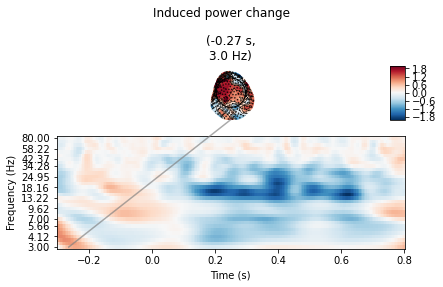

Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)


/scratch/hugwei/49504642.dccn-l029.dccn.nl/ipykernel_15822/1983313533.py:7: RuntimeWarning: Estimated head size (567.9 mm) exceeded 99th percentile for adult head size
  evok.plot_joint(baseline=(-0.35, 0.), mode='zscore', tmin=-0.3, tmax=0.8, title='Evoked power change');
/scratch/hugwei/49504642.dccn-l029.dccn.nl/ipykernel_15822/1983313533.py:7: RuntimeWarning: (X, Y) fit (-104.2, 155.2) more than 20 mm from head frame origin
  evok.plot_joint(baseline=(-0.35, 0.), mode='zscore', tmin=-0.3, tmax=0.8, title='Evoked power change');
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) <

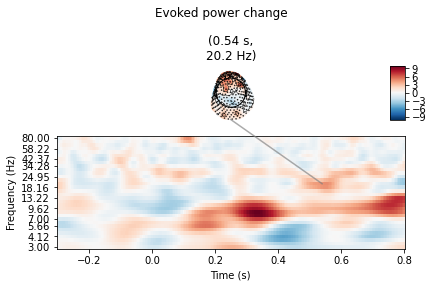

Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)


/scratch/hugwei/49504642.dccn-l029.dccn.nl/ipykernel_15822/1983313533.py:11: RuntimeWarning: Estimated head size (567.9 mm) exceeded 99th percentile for adult head size
  itc.plot_joint(baseline=(-0.35, 0.), mode='zscore', tmin=-0.3, tmax=0.8, title='ITPC');
/scratch/hugwei/49504642.dccn-l029.dccn.nl/ipykernel_15822/1983313533.py:11: RuntimeWarning: (X, Y) fit (-104.2, 155.2) more than 20 mm from head frame origin
  itc.plot_joint(baseline=(-0.35, 0.), mode='zscore', tmin=-0.3, tmax=0.8, title='ITPC');
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


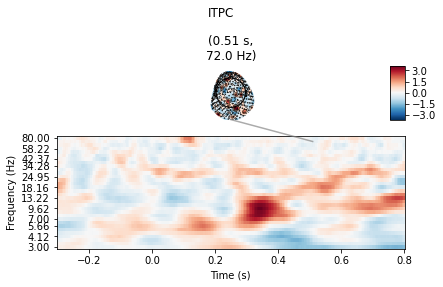

In [29]:
# power change (well not really induced as I'd have to substract evoked  -removing the ERP of averaged epochs- data first )
# abs first -> mean over epochs
avg = fourier.average(lambda x: np.mean(np.abs(x), 0)) # this is solely to create a AverageTFR object
avg.plot_joint(baseline=(-0.35, 0.), mode='zscore', tmin=-0.3, tmax=0.8, title='Induced power change');
# Evoked power: mean first (on complex fourier) -> then abs()
evok = fourier.average(lambda x: np.abs(x.mean(0)))
evok.plot_joint(baseline=(-0.35, 0.), mode='zscore', tmin=-0.3, tmax=0.8, title='Evoked power change');
# ITC
itc = fourier.average(lambda x: np.abs(np.mean(x/np.abs(x), 0)))
itc.plot_joint(baseline=(-0.35, 0.), mode='zscore', tmin=-0.3, tmax=0.8, title='ITPC');

## FOOOF tests

### Figure 2.A

Spectra of French vs Dutch. Possibly from Foof analysis. Or simply pwelched..

In [13]:
#data = np.load('Data/Fooof/sensor_global_fooof_results.pkl', allow_pickle=True)

In [6]:
import joblib
from tqdm.auto import tqdm

class ProgressParallel(joblib.Parallel):
    def __call__(self, *args, **kwargs):
        with tqdm() as self._pbar:
            return joblib.Parallel.__call__(self, *args, **kwargs)

    def print_progress(self):
        self._pbar.total = self.n_dispatched_tasks
        self._pbar.n = self.n_completed_tasks
        self._pbar.refresh()

In [7]:
Xenv = get_feature_signal(feats=['acoustic'], srate=100)

Load stimulus features
Loading feature signal for : ['acoustic']
Done. X shape: (29800, 1)


In [9]:
from scipy.signal import coherence, resample_poly

In [35]:
raws[0]._data.shape

(275, 59600)

In [32]:
resample_poly(Xenv[0], 2, 1).shape

(59600, 1)

In [55]:
fr, coh = coherence(resample_poly(Xenv[0], 2, 1), raws[0]._data.T, axis=0, fs=fs, nfft=1024, nperseg=256)

/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


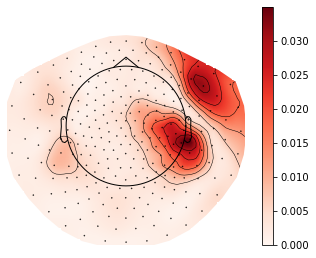

In [62]:
topomap(coh[(fr > 4.5) & (fr < 8), :].mean(0), raws[0].info);

Text(0.5, 1.0, 'Cerebro-Acoustic Coherence')

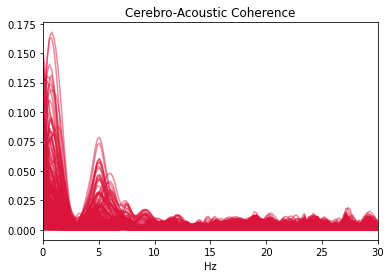

In [53]:
plt.plot(*coherence(resample_poly(Xenv[0], 2, 1), raws[0]._data.T, axis=0, fs=fs, nfft=1024, nperseg=256), color='crimson', alpha=0.5);
plt.xlim([0, 30])
plt.xlabel('Hz')
plt.title('Cerebro-Acoustic Coherence')

Text(0.5, 1.0, 'Grand average power density')

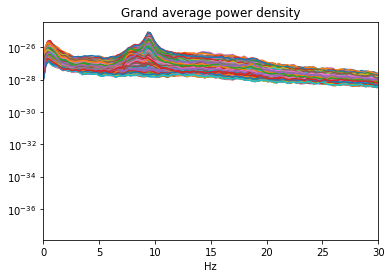

In [54]:
plt.semilogy(freqs, np.mean([Pxx[s]['dutch'] for s in Pxx.keys() if Pxx[s]['dutch'].shape[0]==275], 0).T);
plt.xlabel('Hz')
plt.xlim([0, 30])
plt.title('Grand average power density')

In [158]:
Pxx = {}
for s in tqdm(subjects, desc='Main loop'):
    subject = s[:3] + '-' + s[3:]
    try:
        load_ica = os.path.exists(f'/project/3027007.01/processed/{subject}/meg/audioBook-ica.fif')
        if load_ica:
            ica = mne.preprocessing.read_ica(f'/project/3027007.01/processed/{subject}/meg/audioBook-ica.fif', verbose=False)
            print(f'Loaded ica for subject {subject}')
        raws = extract_story_parts_data(subject, filter=None, ica=True)
        if load_ica:
            bad_comp = find_bad_components(ica, raws[0])
        if bad_comp is not None:
            for k,r in enumerate(raws):
                raws[k] = ica.apply(r.copy(), exclude=bad_comp, verbose=False)
        # filter
        for r in raws:
            r.pick_types(meg=True, ref_meg=False)
            r.filter(0.5, 82)
    except:
        print(f'Skipping subject {subject}')
        continue
    Pxx[s] = {}
    # Dutch
    for r in tqdm(raws[:4], desc=f'Story loop {subject}', leave=False): # Dutch stories only, and only 4 first for simplicity
        freqs, pxx = welch(r._data, fs=r.info['sfreq'], nfft=1024, nperseg=1024, noverlap=512, axis=-1)
    Pxx[s]['dutch'] = pxx
    # French
    for r in tqdm(raws[9:], desc=f'Story loop {subject}', leave=False): # Fench stories only
        freqs, pxx = welch(r._data, fs=r.info['sfreq'], nfft=1024, nperseg=1024, noverlap=512, axis=-1)
    Pxx[s]['french'] = pxx

Main loop:   0%|          | 0/34 [00:00<?, ?it/s]

Loaded ica for subject sub-003


  0%|          | 0/49 [00:00<?, ?it/s]

Did not find any problematic component.


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 

Story loop sub-003:   0%|          | 0/4 [00:00<?, ?it/s]

Story loop sub-003:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded ica for subject sub-004


  0%|          | 0/55 [00:00<?, ?it/s]

Did not find any problematic component.


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 

Story loop sub-004:   0%|          | 0/4 [00:00<?, ?it/s]

Story loop sub-004:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded ica for subject sub-002


  0%|          | 0/54 [00:00<?, ?it/s]

Did not find any problematic component.


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 

Story loop sub-002:   0%|          | 0/4 [00:00<?, ?it/s]

Story loop sub-002:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded ica for subject sub-001


  0%|          | 0/57 [00:00<?, ?it/s]

Components suggested for removal: [1]


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 

Story loop sub-001:   0%|          | 0/4 [00:00<?, ?it/s]

Story loop sub-001:   0%|          | 0/4 [00:00<?, ?it/s]

Skipping subject sub-030
Loaded ica for subject sub-008


  0%|          | 0/54 [00:00<?, ?it/s]

Did not find any problematic component.


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 

Story loop sub-008:   0%|          | 0/4 [00:00<?, ?it/s]

Story loop sub-008:   0%|          | 0/4 [00:00<?, ?it/s]

Skipping subject sub-006
Loaded ica for subject sub-009


  0%|          | 0/54 [00:00<?, ?it/s]

Components suggested for removal: [36]


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 

Story loop sub-009:   0%|          | 0/4 [00:00<?, ?it/s]

Story loop sub-009:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded ica for subject sub-010


  0%|          | 0/55 [00:00<?, ?it/s]

Components suggested for removal: [3, 8, 16, 24, 30, 33, 51]


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 

Story loop sub-010:   0%|          | 0/4 [00:00<?, ?it/s]

Story loop sub-010:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded ica for subject sub-011


  0%|          | 0/56 [00:00<?, ?it/s]

Components suggested for removal: [41]


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 

Story loop sub-011:   0%|          | 0/4 [00:00<?, ?it/s]

Story loop sub-011:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded ica for subject sub-013
Skipping subject sub-013
Loaded ica for subject sub-024


  0%|          | 0/54 [00:00<?, ?it/s]

Components suggested for removal: [17, 31]


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 

Story loop sub-024:   0%|          | 0/4 [00:00<?, ?it/s]

Story loop sub-024:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded ica for subject sub-018


  0%|          | 0/55 [00:00<?, ?it/s]

Did not find any problematic component.


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 

Story loop sub-018:   0%|          | 0/4 [00:00<?, ?it/s]

Story loop sub-018:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded ica for subject sub-019


  0%|          | 0/53 [00:00<?, ?it/s]

Components suggested for removal: [46, 51]


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 

Story loop sub-019:   0%|          | 0/4 [00:00<?, ?it/s]

Story loop sub-019:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded ica for subject sub-005


  0%|          | 0/50 [00:00<?, ?it/s]

Components suggested for removal: [42, 46]


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 

Story loop sub-005:   0%|          | 0/4 [00:00<?, ?it/s]

Story loop sub-005:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded ica for subject sub-020


  0%|          | 0/51 [00:00<?, ?it/s]

Components suggested for removal: [18, 50, 54]


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 

Story loop sub-020:   0%|          | 0/4 [00:00<?, ?it/s]

Story loop sub-020:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded ica for subject sub-021


  0%|          | 0/53 [00:00<?, ?it/s]

Did not find any problematic component.


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 

Story loop sub-021:   0%|          | 0/4 [00:00<?, ?it/s]

Story loop sub-021:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded ica for subject sub-023


  0%|          | 0/55 [00:00<?, ?it/s]

Components suggested for removal: [51]


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 

Story loop sub-023:   0%|          | 0/4 [00:00<?, ?it/s]

Story loop sub-023:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded ica for subject sub-027


  0%|          | 0/58 [00:00<?, ?it/s]

Did not find any problematic component.


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 

Story loop sub-027:   0%|          | 0/4 [00:00<?, ?it/s]

Story loop sub-027:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded ica for subject sub-014


  0%|          | 0/55 [00:00<?, ?it/s]

Components suggested for removal: [4, 8]


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 

Story loop sub-014:   0%|          | 0/4 [00:00<?, ?it/s]

Story loop sub-014:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded ica for subject sub-025


  0%|          | 0/42 [00:00<?, ?it/s]

Did not find any problematic component.


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 

Story loop sub-025:   0%|          | 0/4 [00:00<?, ?it/s]

Story loop sub-025:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded ica for subject sub-026


  0%|          | 0/54 [00:00<?, ?it/s]

Components suggested for removal: [34, 43]


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 

Story loop sub-026:   0%|          | 0/4 [00:00<?, ?it/s]

Story loop sub-026:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded ica for subject sub-015


  0%|          | 0/56 [00:00<?, ?it/s]

Components suggested for removal: [21, 53]


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 

Story loop sub-015:   0%|          | 0/4 [00:00<?, ?it/s]

Story loop sub-015:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded ica for subject sub-028


  0%|          | 0/55 [00:00<?, ?it/s]

Components suggested for removal: [8, 9, 37]


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 

Story loop sub-028:   0%|          | 0/4 [00:00<?, ?it/s]

Story loop sub-028:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded ica for subject sub-029


  0%|          | 0/46 [00:00<?, ?it/s]

Components suggested for removal: [0, 4, 28]


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 

Story loop sub-029:   0%|          | 0/4 [00:00<?, ?it/s]

Story loop sub-029:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded ica for subject sub-032


  0%|          | 0/49 [00:00<?, ?it/s]

Did not find any problematic component.


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 

Story loop sub-032:   0%|          | 0/4 [00:00<?, ?it/s]

Story loop sub-032:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded ica for subject sub-033


  0%|          | 0/53 [00:00<?, ?it/s]

Did not find any problematic component.


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 

Story loop sub-033:   0%|          | 0/4 [00:00<?, ?it/s]

Story loop sub-033:   0%|          | 0/4 [00:00<?, ?it/s]

Skipping subject sub-007
Loaded ica for subject sub-017


  0%|          | 0/54 [00:00<?, ?it/s]

Did not find any problematic component.


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 

Story loop sub-017:   0%|          | 0/4 [00:00<?, ?it/s]

Story loop sub-017:   0%|          | 0/4 [00:00<?, ?it/s]

Skipping subject sub-034
Loaded ica for subject sub-037


  0%|          | 0/54 [00:00<?, ?it/s]

Did not find any problematic component.


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 

Story loop sub-037:   0%|          | 0/4 [00:00<?, ?it/s]

Story loop sub-037:   0%|          | 0/4 [00:00<?, ?it/s]

Skipping subject sub-031
Skipping subject sub-035
Reading audioBook-ica.fif ...
Skipping subject sub-036


In [160]:
np.savez('all_psds.npz', **Pxx)

In [34]:
mdl = fooof.FOOOF(peak_width_limits=(0.3, 12), peak_threshold=1.5)
mdl.fit(freqs, Pxx['sub017']['dutch'][12], [1.5, 60.])

And removing sub002
No peak detected in subject sub025
No peak detected in subject sub032
No peak detected in subject sub017


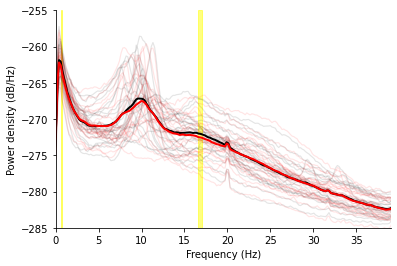

In [131]:
f = plt.figure()
ax = f.add_subplot()
avg_power = {'dutch': [], 'french': []}
for subj, subj_power in Pxx.items():
    # Test if the spectrum is well behaved
    mdl = fooof.FOOOF(peak_width_limits=(0.3, 12), peak_threshold=1.75)
    mdl.fit(freqs, subj_power['dutch'][12], [1.5, 60.])
    if mdl.get_results().peak_params.size == 0: # NO PEAKS!
        print(f'No peak detected in subject {subj}')
        #Pxx.pop(subj)
        continue
    # And of course, remove sub-002!!!
    if subj == 'sub002':
        print('And removing sub002')
        continue
        
        
    p = subj_power['dutch'].mean(0) # mean across channels
    p = 10*np.log10(p)
    ax.plot(freqs, p, alpha=0.1, color='k', lw=1.2)
    avg_power['dutch'].append(p)
    
    p = subj_power['french'].mean(0) # mean across channels
    p = 10*np.log10(p)
    ax.plot(freqs, p, alpha=0.1, color='r', lw=1.2)
    avg_power['french'].append(p)
    
# Plot average 
ax.plot(freqs, np.mean(avg_power['dutch'], 0), color='k', lw=2.)
ax.plot(freqs, np.mean(avg_power['french'], 0), color='r', lw=2.)

plt.xlim([0, 39])
plt.ylim([-285, -255])
sns.despine()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power density (dB/Hz)')

H1, pvals_corrected = fdr_correction(ttest_1samp(condition1 - condition2, 0.0, axis=0).pvalue[:256]) # until 50Hz
# Find cluster bondaries:
nnz = np.nonzero(H1)[0]
clus = []
in_clus = False
for k, nz in enumerate(nnz):
    if not in_clus:
        current_cluster = []
        current_cluster.append(nz)
        in_clus = True
    
    if k > 0 and nz == nnz[k-1]+1: # in cluster
        if (k < len(nnz)-1 and nz != nnz[k+1]-1) or k==len(nnz)-1: # last one
            current_cluster.append(nz)
            clus.append(current_cluster.copy())
            in_clus = False
        else:
            continue
for cluster in clus:
    plt.axvspan(freqs[cluster[0]], freqs[cluster[1]], alpha=0.5, color='yellow')

In [84]:
from scipy.stats import ttest_1samp
from mne.stats import fdr_correction

In [142]:
# Define conditions
condition1 = np.asarray(avg_power['dutch'])
condition2 = np.asarray(avg_power['french'])

T_obs, clusters, p_values, _ = mne.stats.permutation_cluster_1samp_test(condition1 - condition2, tail=0, t_power=2)

Using a threshold of 2.073873
stat_fun(H1): min=-1.738004 max=4.465583
Running initial clustering
Found 2 clusters
Permuting 1023 times...


  0%|          |  : 0/1023 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


In [143]:
p_values

array([0.13867188, 0.04589844])

In [37]:
raws = extract_story_parts_data(subject, filter=None, ica=True)
for r in raws:
    r.pick_types(meg=True, ref_meg=False)
    r.filter(0.5, 82)

In [8]:
fs = raws[0].info['sfreq']

Text(0.5, 0, 'Frequency (Hz)')

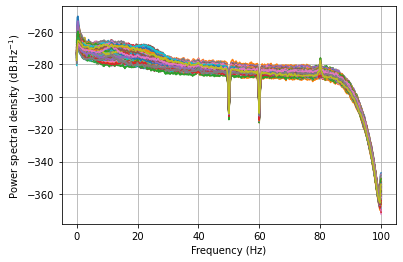

In [9]:
freqs, pxx = welch(raws[0]._data, fs=fs, nfft=1024, nperseg=1024, noverlap=512, axis=-1)
plt.plot(freqs, 10*np.log10(pxx.T))
plt.grid(True)
plt.ylabel('Power spectral density (dB.Hz$^{-1}$)')
plt.xlabel('Frequency (Hz)')

#### Theta peaks

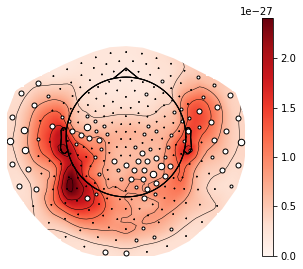

In [261]:
topomap(PSDs[-1][:, (4 < freqs) & (freqs < 7.5)].mean(-1), info_max, mask=mask>3, mask_params=dict(marker='o', markerfacecolor='w', markeredgecolor='k',
                linewidth=0, markersize=3));
topomap(PSDs[-1][:, (4 < freqs) & (freqs < 7.5)].mean(-1)*np.nan, info_max, mask=mask>4, mask_params=dict(marker='o', markerfacecolor='w', markeredgecolor='k',
                linewidth=0, markersize=5), ax=plt.gca(), colorbar=False);
topomap(PSDs[-1][:, (4 < freqs) & (freqs < 7.5)].mean(-1)*np.nan, info_max, mask=mask>6, mask_params=dict(marker='o', markerfacecolor='w', markeredgecolor='k',
                linewidth=0, markersize=6.5), ax=plt.gca(), colorbar=False);

21 sub-028
    Read 5 compensation matrices
Removing 5 compensators from info because not all compensation channels were picked.


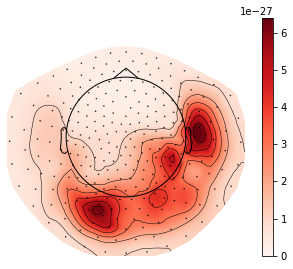

In [347]:
s_id = np.random.randint(len(subj_included))
print(s_id, subj_included[s_id])
info = mne.io.read_info(os.path.join(DATA_PATH, 'processed', subj_included[s_id], 'meg', 'audioBook-filtered-ICAed-raw.fif'))
info = mne.pick_info(info, sel=mne.pick_types(info, meg=True, ref_meg=False))
topomap(PSDs[s_id][:, (4 < freqs) & (freqs < 7.5)].mean(-1), info);

In [89]:
# MASK on 275 channels
mask = np.zeros(len(info_max.ch_names))
for k, c in enumerate(info_max.ch_names):
    for s, chlist in theta_chans.items():
        if c in chlist:
            mask[k] += 1
            
#Mask on 269 channels
mask = np.zeros(len(info_269.ch_names))
for k, c in enumerate(info_269.ch_names):
    for s, chlist in theta_chans.items():
        if c in chlist:
            mask[k] += 1

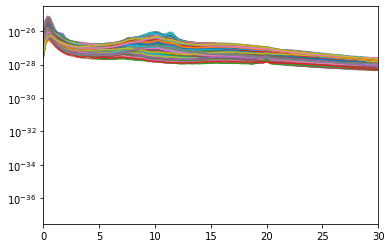

<Figure size 432x288 with 0 Axes>

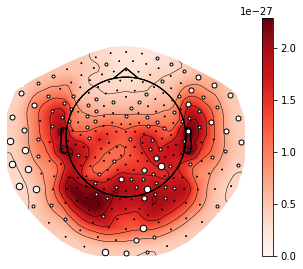

In [93]:
power = np.mean([p for k,p in enumerate(PSDs) if (p.shape[0]==269) and (k!=18) and (k!=2) and (k!=8)], 0).T # had to remove some nasty subjects
plt.semilogy(freqs, power);
plt.xlim([0, 30])
plt.figure();
topomap(power[(freqs<7.7) & (freqs>4.5)].mean(0), info_269, mask=mask>1, mask_params=dict(marker='o', markerfacecolor='w', markeredgecolor='k',
                linewidth=0, markersize=3));
topomap(power[(freqs<7.7) & (freqs>4.5)].mean(0)*np.nan, info_269, mask=mask>2, mask_params=dict(marker='o', markerfacecolor='w', markeredgecolor='k',
                linewidth=0, markersize=5), ax=plt.gca(), colorbar=False);
topomap(power[(freqs<7.7) & (freqs>4.5)].mean(0)*np.nan, info_269, mask=mask>3, mask_params=dict(marker='o', markerfacecolor='w', markeredgecolor='k',
                linewidth=0, markersize=6.5), ax=plt.gca(), colorbar=False);
# topomap(power[(freqs<7.7) & (freqs>4.5)].mean(0), info_269);

In [19]:
freq_range = [2, 80]
theta_chans = {}
info_max = info.copy()
PSDs = []

for s in tqdm(subjects, desc='Main loop'):
    subject = s[:3] + '-' + s[3:]
    try:
        raws = extract_story_parts_data(subject, filter=None, ica=True)
        # filter
        for r in raws:
            r.pick_types(meg=True, ref_meg=False)
            r.filter(0.5, 82)
        # Update info structures
        if len(raws[0].ch_names)==269: info_269 =  raws[0].info
        if len(raws[0].ch_names) > len(info_max.ch_names): info_max =  raws[0].info
    except:
        print(f'Skipping subject {subject}')
        continue
    chans = []
    PXX = []
    for r in tqdm(raws[:4], desc=f'Story loop {subject}', leave=False): # Dutch stories only, and only 4 first for simplicity
        freqs, pxx = welch(r._data, fs=fs, nfft=1024, nperseg=1024, noverlap=512, axis=-1)
        PXX.append(pxx)
        for kc, px in tqdm(enumerate(pxx), total=len(pxx), leave=False, desc='sensor loop'):
            fof = fooof.FOOOF(peak_width_limits=(0.3, 10.))
            fof.add_data(freqs, px, freq_range=freq_range)
            fof.fit()
            # fof.print_results()
            res = fof.get_results()
            peaks = res.peak_params[:, 0].ravel()
            if np.any(peaks < 7.5): # looking for theta peaks
                chans.append(raws[0].ch_names[kc])
    PSDs.append(np.mean(PXX, 0))
    theta_chans[subject] = list(set(chans))
    #subj_included.append(subject)

Main loop:   0%|          | 0/34 [00:00<?, ?it/s]

Story loop sub-003:   0%|          | 0/4 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

Story loop sub-004:   0%|          | 0/4 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

Story loop sub-002:   0%|          | 0/4 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

Story loop sub-001:   0%|          | 0/4 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

Skipping subject sub-030


Story loop sub-008:   0%|          | 0/4 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

Skipping subject sub-006


Story loop sub-009:   0%|          | 0/4 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

Story loop sub-010:   0%|          | 0/4 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

Story loop sub-011:   0%|          | 0/4 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

Story loop sub-013:   0%|          | 0/4 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

Story loop sub-024:   0%|          | 0/4 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

Story loop sub-018:   0%|          | 0/4 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

Story loop sub-019:   0%|          | 0/4 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

Story loop sub-005:   0%|          | 0/4 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

Story loop sub-020:   0%|          | 0/4 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

Story loop sub-021:   0%|          | 0/4 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

Story loop sub-023:   0%|          | 0/4 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

Story loop sub-027:   0%|          | 0/4 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

Story loop sub-014:   0%|          | 0/4 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

Story loop sub-025:   0%|          | 0/4 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

Story loop sub-026:   0%|          | 0/4 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

Story loop sub-015:   0%|          | 0/4 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/266 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/266 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/266 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/266 [00:00<?, ?it/s]

Story loop sub-028:   0%|          | 0/4 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/269 [00:00<?, ?it/s]

Story loop sub-029:   0%|          | 0/4 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/267 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/267 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/267 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/267 [00:00<?, ?it/s]

Story loop sub-032:   0%|          | 0/4 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/267 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/267 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/267 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/267 [00:00<?, ?it/s]

Story loop sub-033:   0%|          | 0/4 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/267 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/267 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/267 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/267 [00:00<?, ?it/s]

Skipping subject sub-007


Story loop sub-017:   0%|          | 0/4 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/267 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/267 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/267 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/267 [00:00<?, ?it/s]

Skipping subject sub-034


Story loop sub-037:   0%|          | 0/4 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/275 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/275 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/275 [00:00<?, ?it/s]

sensor loop:   0%|          | 0/275 [00:00<?, ?it/s]

Skipping subject sub-031
Skipping subject sub-035
Reading audioBook-ica.fif ...
Skipping subject sub-036


##  Computing FOOOF on every subject 

This results are saved on disk (see below).

In [94]:
freq_range = [2, 80]
aperiodic_params = []
peak_freqs = []
peak_widths = []
r2 = []
subj_included = []
PSDs = []

for s in tqdm(subjects, desc='Main loop'):
    subject = s[:3] + '-' + s[3:]
    try:
        raws = extract_story_parts_data(subject, filter=None, ica=True)
        for r in raws:
            r.pick_types(meg=True, ref_meg=False)
            r.filter(0.5, 82)
    except:
        print(f'Skipping subject {subject}')
        continue
    fof = fooof.FOOOF(peak_width_limits=(0.3, 10.))
    for r in tqdm(raws[:9], desc=f'Story loop {subject}', leave=False): # Dutch stories only
        freqs, pxx = welch(r._data, fs=fs, nfft=1024, nperseg=1024, noverlap=512, axis=-1)
        for px in pxx:
            fof.add_data(freqs, px, freq_range=freq_range)
    fof.fit()
    fof.print_results()
    res = fof.get_results()
    aperiodic_params.append(res.aperiodic_params)
    peak_freqs.append(res.peak_params[:, 0].ravel())
    peak_widths.append(res.peak_params[:, -1].ravel())
    r2.append(res.r_squared)
    subj_included.append(subject)
    PSDs.append(pxx)

Main loop:   0%|          | 0/34 [00:00<?, ?it/s]

Story loop sub-003:   0%|          | 0/9 [00:00<?, ?it/s]

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 80 Hz                        
                                 Frequency Resolution is 0.20 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -26.9629, 1.0120                                         
                                                                                                  
                                       2 peaks were found:                                        
          

Story loop sub-004:   0%|          | 0/9 [00:00<?, ?it/s]

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 80 Hz                        
                                 Frequency Resolution is 0.20 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -25.9637, 1.4102                                         
                                                                                                  
                                       1 peaks were found:                                        
          

Story loop sub-002:   0%|          | 0/9 [00:00<?, ?it/s]

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 80 Hz                        
                                 Frequency Resolution is 0.20 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -26.5162, 1.2814                                         
                                                                                                  
                                       2 peaks were found:                                        
          

Story loop sub-001:   0%|          | 0/9 [00:00<?, ?it/s]

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 80 Hz                        
                                 Frequency Resolution is 0.20 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -25.9598, 1.4298                                         
                                                                                                  
                                       2 peaks were found:                                        
          

Story loop sub-008:   0%|          | 0/9 [00:00<?, ?it/s]

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 80 Hz                        
                                 Frequency Resolution is 0.20 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -26.0810, 1.3732                                         
                                                                                                  
                                       3 peaks were found:                                        
          

Story loop sub-009:   0%|          | 0/9 [00:00<?, ?it/s]

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 80 Hz                        
                                 Frequency Resolution is 0.20 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -26.5978, 1.1647                                         
                                                                                                  
                                       3 peaks were found:                                        
          

Story loop sub-010:   0%|          | 0/9 [00:00<?, ?it/s]

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 80 Hz                        
                                 Frequency Resolution is 0.20 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -25.4152, 1.7054                                         
                                                                                                  
                                       2 peaks were found:                                        
          

Story loop sub-011:   0%|          | 0/9 [00:00<?, ?it/s]

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 80 Hz                        
                                 Frequency Resolution is 0.20 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -26.0409, 1.3758                                         
                                                                                                  
                                       2 peaks were found:                                        
          

Story loop sub-013:   0%|          | 0/9 [00:00<?, ?it/s]

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 80 Hz                        
                                 Frequency Resolution is 0.20 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -26.3484, 1.2702                                         
                                                                                                  
                                       4 peaks were found:                                        
          

Story loop sub-024:   0%|          | 0/9 [00:00<?, ?it/s]

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 80 Hz                        
                                 Frequency Resolution is 0.20 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -26.4814, 1.1837                                         
                                                                                                  
                                       3 peaks were found:                                        
          

Story loop sub-018:   0%|          | 0/9 [00:00<?, ?it/s]

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 80 Hz                        
                                 Frequency Resolution is 0.20 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -26.4202, 1.3243                                         
                                                                                                  
                                       3 peaks were found:                                        
          

Story loop sub-019:   0%|          | 0/9 [00:00<?, ?it/s]

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 80 Hz                        
                                 Frequency Resolution is 0.20 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -26.1158, 1.4490                                         
                                                                                                  
                                       4 peaks were found:                                        
          

Story loop sub-005:   0%|          | 0/9 [00:00<?, ?it/s]

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 80 Hz                        
                                 Frequency Resolution is 0.20 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -25.9618, 1.4251                                         
                                                                                                  
                                       2 peaks were found:                                        
          

Story loop sub-020:   0%|          | 0/9 [00:00<?, ?it/s]

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 80 Hz                        
                                 Frequency Resolution is 0.20 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -25.9328, 1.4272                                         
                                                                                                  
                                       2 peaks were found:                                        
          

Story loop sub-021:   0%|          | 0/9 [00:00<?, ?it/s]

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 80 Hz                        
                                 Frequency Resolution is 0.20 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -26.4232, 1.2563                                         
                                                                                                  
                                       2 peaks were found:                                        
          

Story loop sub-023:   0%|          | 0/9 [00:00<?, ?it/s]

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 80 Hz                        
                                 Frequency Resolution is 0.20 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -26.0752, 1.3943                                         
                                                                                                  
                                       1 peaks were found:                                        
          

Story loop sub-027:   0%|          | 0/9 [00:00<?, ?it/s]

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 80 Hz                        
                                 Frequency Resolution is 0.20 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -25.6003, 1.7010                                         
                                                                                                  
                                       3 peaks were found:                                        
          

Story loop sub-014:   0%|          | 0/9 [00:00<?, ?it/s]

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 80 Hz                        
                                 Frequency Resolution is 0.20 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -25.6303, 1.5698                                         
                                                                                                  
                                       1 peaks were found:                                        
          

Story loop sub-025:   0%|          | 0/9 [00:00<?, ?it/s]

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 80 Hz                        
                                 Frequency Resolution is 0.20 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -26.5288, 1.2141                                         
                                                                                                  
                                       2 peaks were found:                                        
          

Story loop sub-026:   0%|          | 0/9 [00:00<?, ?it/s]

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 80 Hz                        
                                 Frequency Resolution is 0.20 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -25.6726, 1.6375                                         
                                                                                                  
                                       2 peaks were found:                                        
          

Story loop sub-015:   0%|          | 0/9 [00:00<?, ?it/s]

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 80 Hz                        
                                 Frequency Resolution is 0.20 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -25.3749, 1.7371                                         
                                                                                                  
                                       2 peaks were found:                                        
          

Story loop sub-028:   0%|          | 0/9 [00:00<?, ?it/s]

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 80 Hz                        
                                 Frequency Resolution is 0.20 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -25.7819, 1.5785                                         
                                                                                                  
                                       3 peaks were found:                                        
          

Story loop sub-029:   0%|          | 0/9 [00:00<?, ?it/s]

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 80 Hz                        
                                 Frequency Resolution is 0.20 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -26.2470, 1.3061                                         
                                                                                                  
                                       2 peaks were found:                                        
          

Story loop sub-032:   0%|          | 0/9 [00:00<?, ?it/s]

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 80 Hz                        
                                 Frequency Resolution is 0.20 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -26.0133, 1.3948                                         
                                                                                                  
                                       2 peaks were found:                                        
          

Story loop sub-033:   0%|          | 0/9 [00:00<?, ?it/s]

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 80 Hz                        
                                 Frequency Resolution is 0.20 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -26.1646, 1.3271                                         
                                                                                                  
                                       3 peaks were found:                                        
          

Story loop sub-017:   0%|          | 0/9 [00:00<?, ?it/s]

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 80 Hz                        
                                 Frequency Resolution is 0.20 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -26.3122, 1.3055                                         
                                                                                                  
                                       0 peaks were found:                                        
          

Story loop sub-037:   0%|          | 0/9 [00:00<?, ?it/s]

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 80 Hz                        
                                 Frequency Resolution is 0.20 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -26.2221, 1.3924                                         
                                                                                                  
                                       3 peaks were found:                                        
          

In [120]:
import  matplotlib.colors as colors

In [134]:
norm = colors.LogNorm(vmin=0.01, vmax=10)
norm = colors.Normalize(vmin=0.01, vmax=10)

In [179]:
PSDs[0].shape

(269, 513)

### Figure 2.B

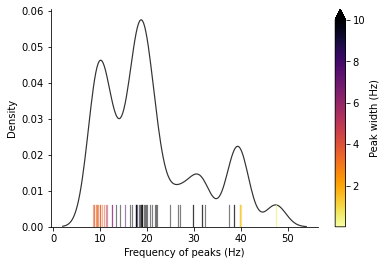

In [153]:
cmap = 'inferno_r'
sns.kdeplot(x=np.concatenate(peak_freqs), bw_method=0.2, color=[0.2]*3, lw=1.2)
for p,w in zip(np.concatenate(peak_freqs), np.concatenate(peak_widths)):
    plt.axvline(p, alpha=0.5, lw=1.2, color=plt.cm.get_cmap(cmap)(norm(w)), ymax=0.1)
plt.xlabel('Frequency of peaks (Hz)')
ax = plt.gca()
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), extend='max', label='Peak width (Hz)')
sns.despine(ax=ax)

(0.0, 1.0)

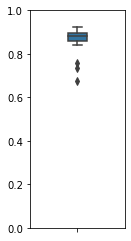

In [170]:
f, ax = plt.subplots(1, 1, subplot_kw={'aspect':2.3})
sns.boxplot(y=r2, width=0.2)
plt.ylim([0., 1])

In [222]:
results = {'subject':subj_included, 'r2':r2, 'peak':peak_freqs, 'width':peak_widths}

In [9]:
import pandas as pd

In [224]:
df = pd.DataFrame(results)

In [227]:
df.to_pickle('Data/Fooof/sensor_global_fooof_results.pkl')

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 80 Hz                        
                                 Frequency Resolution is 0.20 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -25.4330, 1.7080                                         
                                                                                                  
                                       4 peaks were found:                                        
          

(-29.0, -25.0)

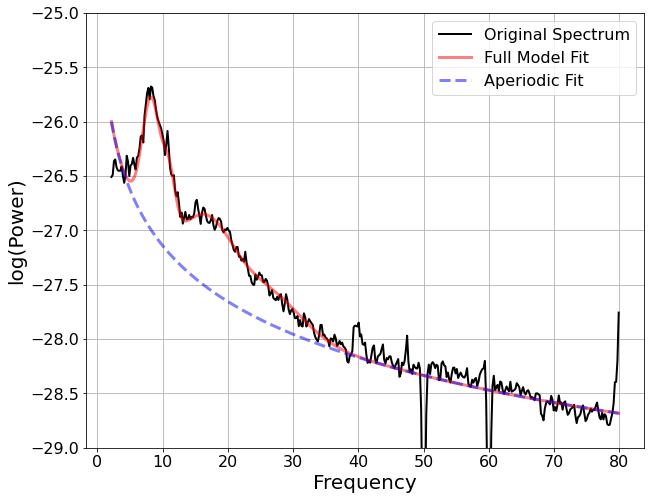

In [36]:
# Set the frequency range to fit the model
freq_range = [2, 80]

# Report: fit the model, print the resulting parameters, and plot the reconstruction
fof.report(freqs, pxx, freq_range)
plt.ylim([-29, -25])

## All figures in ONE PANEL

These are the final figure cells

In [5]:
import glob

In [6]:
class InterpolationError(Exception):
    """
    A placeholder for error handling.
    """
    def __init__(self, *args):
        super().__init__()
        self.args = args
        self.message = None
        if len(args) > 0: self.message = args[0]
    def __str__(self):
        if self.message is not None:
            return self.message
        else:
            return str(self.args)

In [7]:
info_269 = mne.io.read_info(os.path.join(DATA_PATH, 'processed', 'sub-026', 'meg', 'audioBook-filtered-ICAed-raw.fif'))
info_269 = mne.pick_info(info_269, mne.pick_types(info_269, meg=True, ref_meg=False))

    Read 5 compensation matrices
Removing 5 compensators from info because not all compensation channels were picked.


In [8]:
# Info with 267 channels:
bads = ['MLT41', 'MRO52']
info = mne.io.read_info(os.path.join(DATA_PATH, 'processed', 'sub-026', 'meg', 'audioBook-filtered-ICAed-raw.fif'))
info = mne.pick_info(info, mne.pick_types(info, meg=True, ref_meg=False, exclude=bads))
#info = mne.pick_info(info, mne.pick_types(info, meg=True, ref_meg=False, exclude=[]))

    Read 5 compensation matrices
Removing 5 compensators from info because not all compensation channels were picked.


In [9]:
paper_fontsizes = {
    'axes.labelsize': 10,
    'axes.titlesize': 11,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 10
}

palette = sns.color_palette(['#127C6F', '#2AAD9D', '#AA43A0', '#7A4B9B', 'orange'])
palette = sns.color_palette([ '#2AAD9D', '#7A4B9B', 'orange'])

In [10]:
from scipy.signal import coherence, resample_poly
fs = info['sfreq']
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.transforms as transforms

In [84]:
Xenv = get_feature_signal(feats=['acoustic'], srate=100)

Load stimulus features
Loading feature signal for : ['acoustic']
Done. X shape: (29800, 1)


In [212]:
nl_cohs = []
fr_cohs = []
freqs = np.logspace(*np.log10([3, 80]), 32)
ncycles = np.linspace(2, 7, 32)
TFRs = {'ITC':[], 'Power':[]}

In [ ]:
for subject in tqdm(subjects):
    subject = subject[:3] + '-' + subject[3:]
    # Loading data in
    try:
        load_ica = os.path.exists(f'/project/3027007.01/processed/{subject}/meg/audioBook-ica.fif')
        if load_ica:
            ica = mne.preprocessing.read_ica(f'/project/3027007.01/processed/{subject}/meg/audioBook-ica.fif', verbose=False)
            print(f'Loaded ica for subject {subject}')
        raws = extract_story_parts_data(subject, filter=None, ica=True)
        # Doing the ICA rejection BEFORE filtering and channel picking (most importantly the latter as the ICA channel number must match our data)
        if load_ica:
            bad_comp = find_bad_components(ica, raws[0])
        if bad_comp is not None:
            for k,r in enumerate(raws):
                raws[k] = ica.apply(r.copy(), exclude=bad_comp, verbose=False)
        for kstory, r in tqdm(enumerate(raws), total=len(raws), leave=False, desc='Within subject filtering and interpolating (if needed)'):
            #r.pick_types(meg=True, ref_meg=False)
            # pick on the info 267 chanels
            r.pick_channels(info.ch_names, ordered=True)
            r.filter(0.5, 82)
            try:
                # if less than 267 channels after that we have to interpolate
                if len(r.ch_names) != len(info.ch_names):
                    print(f'Need to interpolate ({subject})')
                    # Find missing channels
                    missings = []
                    for c in info.ch_names:
                        if c not in r.ch_names:
                            missings.append(c)
                    r.add_channels([mne.io.RawArray(np.zeros((len(missings), len(r.times))), mne.pick_info(info, sel=mne.pick_channels(info.ch_names, missings), verbose=False), verbose=False)], force_update_info=True)
                    r.info['bads'] = missings
                    r.interpolate_bads()
                    r.reorder_channels(info.ch_names)
                    print(f"Interpolation Done, interpolated: {missings}")
            except Exception as e:
                raise InterpolationError(f"Couln't interpolate subject {subject}")
    except FileNotFoundError as e:
        print(f"Error: {e.args[0]}, it seems {e.filename} does not exist")
        continue
    except InterpolationError as e:
        print(e)
    except Exception as e:
        print(f'Unknown problem loading {subject}. See error message below')
        print(e)
        continue
        
    # Word Epoched
    events = mne.event.find_events(mne.io.RawArray(X[0].T, mne.create_info(['onset'], 100, ch_types='stim')).resample(200), verbose=False)
    eventid = {'Word onset': events[0, 2]}
    events[:, 0] += raws[0].first_samp
    epochs = mne.Epochs(raws[0], events, eventid, tmin=-0.4, tmax=1.0, baseline=None, preload=True, verbose=False)
    
    # TFRs
    print(f"Computing Time-frequency representations {subject}")
    power, itc = mne.time_frequency.tfr_morlet(epochs[:500], zfreqs, ncycles, use_fft=True, return_itc=True, n_jobs=2, average=True, verbose=False)
    print('Done')
    TFRs['ITC'].append(itc)
    TFRs['Power'].append(power)
    
    # Compute Coherence for each subject and store it
    cohs = []
    for x, r in tqdm(zip(Xenv, raws), total=len(raws), desc='Computing Coherences', leave=False):
        fr, coh = coherence(resample_poly(x, 2, 1), r._data.T, axis=0, fs=fs, nfft=1024, nperseg=256)
        cohs.append(coh)
    nl_cohs.append(np.mean(cohs[:9], 0))
    fr_cohs.append(np.mean(cohs[9:], 0))

  0%|          | 0/34 [00:00<?, ?it/s]

Loaded ica for subject sub-003


  0%|          | 0/49 [00:00<?, ?it/s]

Did not find any problematic component.


Within subject filtering and interpolating (if needed):   0%|          | 0/13 [00:00<?, ?it/s]

Creating RawArray with float64 data, n_channels=1, n_times=29800
    Range : 0 ... 29799 =      0.000 ...   297.990 secs
Ready.
938 events found
Event IDs: [5]
938 events found
Event IDs: [5]
Computing Time-frequency representations sub-003
Done


Computing Coherences:   0%|          | 0/13 [00:00<?, ?it/s]

Loaded ica for subject sub-004


  0%|          | 0/55 [00:00<?, ?it/s]

Did not find any problematic component.


Within subject filtering and interpolating (if needed):   0%|          | 0/13 [00:00<?, ?it/s]

Creating RawArray with float64 data, n_channels=1, n_times=29800
    Range : 0 ... 29799 =      0.000 ...   297.990 secs
Ready.
938 events found
Event IDs: [5]
938 events found
Event IDs: [5]
Computing Time-frequency representations sub-004
Done


Computing Coherences:   0%|          | 0/13 [00:00<?, ?it/s]

Loaded ica for subject sub-002


  0%|          | 0/54 [00:00<?, ?it/s]

Did not find any problematic component.


Within subject filtering and interpolating (if needed):   0%|          | 0/13 [00:00<?, ?it/s]

Creating RawArray with float64 data, n_channels=1, n_times=29800
    Range : 0 ... 29799 =      0.000 ...   297.990 secs
Ready.
938 events found
Event IDs: [5]
938 events found
Event IDs: [5]
Computing Time-frequency representations sub-002
Done


Computing Coherences:   0%|          | 0/13 [00:00<?, ?it/s]

Loaded ica for subject sub-001


  0%|          | 0/57 [00:00<?, ?it/s]

Components suggested for removal: [1]


Within subject filtering and interpolating (if needed):   0%|          | 0/13 [00:00<?, ?it/s]

Creating RawArray with float64 data, n_channels=1, n_times=29800
    Range : 0 ... 29799 =      0.000 ...   297.990 secs
Ready.
938 events found
Event IDs: [5]
938 events found
Event IDs: [5]
Computing Time-frequency representations sub-001
Done


Computing Coherences:   0%|          | 0/13 [00:00<?, ?it/s]

Error: fname does not exist: /project/3027007.01/processed/sub-030/meg/audioBook-raw.fif, it seems None does not exist
Loaded ica for subject sub-008


  0%|          | 0/54 [00:00<?, ?it/s]

Did not find any problematic component.


Within subject filtering and interpolating (if needed):   0%|          | 0/13 [00:00<?, ?it/s]

Creating RawArray with float64 data, n_channels=1, n_times=29800
    Range : 0 ... 29799 =      0.000 ...   297.990 secs
Ready.
938 events found
Event IDs: [5]
938 events found
Event IDs: [5]
Computing Time-frequency representations sub-008
Done


Computing Coherences:   0%|          | 0/13 [00:00<?, ?it/s]

Error: fname does not exist: /project/3027007.01/processed/sub-006/meg/audioBook-raw.fif, it seems None does not exist
Loaded ica for subject sub-009


  0%|          | 0/54 [00:00<?, ?it/s]

Components suggested for removal: [36]


Within subject filtering and interpolating (if needed):   0%|          | 0/13 [00:00<?, ?it/s]

Creating RawArray with float64 data, n_channels=1, n_times=29800
    Range : 0 ... 29799 =      0.000 ...   297.990 secs
Ready.
938 events found
Event IDs: [5]
938 events found
Event IDs: [5]
Computing Time-frequency representations sub-009
Done


Computing Coherences:   0%|          | 0/13 [00:00<?, ?it/s]

Loaded ica for subject sub-010


  0%|          | 0/55 [00:00<?, ?it/s]

Components suggested for removal: [3, 8, 16, 24, 30, 33, 51]


Within subject filtering and interpolating (if needed):   0%|          | 0/13 [00:00<?, ?it/s]

Creating RawArray with float64 data, n_channels=1, n_times=29800
    Range : 0 ... 29799 =      0.000 ...   297.990 secs
Ready.
938 events found
Event IDs: [5]
938 events found
Event IDs: [5]
Computing Time-frequency representations sub-010
Done


Computing Coherences:   0%|          | 0/13 [00:00<?, ?it/s]

Loaded ica for subject sub-011


  0%|          | 0/56 [00:00<?, ?it/s]

Components suggested for removal: [41]


Within subject filtering and interpolating (if needed):   0%|          | 0/13 [00:00<?, ?it/s]

Creating RawArray with float64 data, n_channels=1, n_times=29800
    Range : 0 ... 29799 =      0.000 ...   297.990 secs
Ready.
938 events found
Event IDs: [5]
938 events found
Event IDs: [5]
Computing Time-frequency representations sub-011


In [ ]:
# Trying to save everything so I can get it back quick before I close :(
for ksub, (itc_data, power_data, coherence_data) in enumerate(zip(TFRs['ITC'], TFRs['Power'], zip(nl_cohs, fr_cohs))):
    itc_data.save(f'./Data/tfr_itc_sub{ksub}-tfr.h5')
    power_data.save(f'./Data/tfr_pow_sub{ksub}-tfr.h5')
    np.savez(f'./Data/coherence_nl_fr_sub{ksub}.npz', nl_coh=coherence_data[0], fr_coh=coherence_data[1])

In [89]:
# Loading them all:
nl_cohs = []
fr_cohs = []
for f in glob.glob('./Data/coherence_nl_fr_sub*.npz'):
    data = np.load(f)
    nl_cohs.append(data['nl_coh'])
    fr_cohs.append(data['fr_coh'])
    data.close()

In [11]:
# Loading them all:
freqs = np.logspace(*np.log10([3, 80]), 32)
ncycles = np.linspace(2, 7, 32)
TFRs = {'ITC':[], 'Power':[]}
for f in tqdm(glob.glob('./Data/tfr_itc_sub*-tfr.h5'), total=len(glob.glob('./Data/tfr_itc_sub*-tfr.h5'))):
    TFRs['ITC'].append(mne.time_frequency.read_tfrs(f))
    TFRs['Power'].append(mne.time_frequency.read_tfrs(f.replace('itc', 'pow')))

  0%|          | 0/25 [00:00<?, ?it/s]

Reading ./Data/tfr_itc_sub0-tfr.h5 ...
Reading ./Data/tfr_pow_sub0-tfr.h5 ...
Reading ./Data/tfr_itc_sub1-tfr.h5 ...
Reading ./Data/tfr_pow_sub1-tfr.h5 ...
Reading ./Data/tfr_itc_sub2-tfr.h5 ...
Reading ./Data/tfr_pow_sub2-tfr.h5 ...
Reading ./Data/tfr_itc_sub3-tfr.h5 ...
Reading ./Data/tfr_pow_sub3-tfr.h5 ...
Reading ./Data/tfr_itc_sub4-tfr.h5 ...
Reading ./Data/tfr_pow_sub4-tfr.h5 ...
Reading ./Data/tfr_itc_sub5-tfr.h5 ...
Reading ./Data/tfr_pow_sub5-tfr.h5 ...
Reading ./Data/tfr_itc_sub6-tfr.h5 ...
Reading ./Data/tfr_pow_sub6-tfr.h5 ...
Reading ./Data/tfr_itc_sub7-tfr.h5 ...
Reading ./Data/tfr_pow_sub7-tfr.h5 ...
Reading ./Data/tfr_itc_sub8-tfr.h5 ...
Reading ./Data/tfr_pow_sub8-tfr.h5 ...
Reading ./Data/tfr_itc_sub9-tfr.h5 ...
Reading ./Data/tfr_pow_sub9-tfr.h5 ...
Reading ./Data/tfr_itc_sub10-tfr.h5 ...
Reading ./Data/tfr_pow_sub10-tfr.h5 ...
Reading ./Data/tfr_itc_sub11-tfr.h5 ...
Reading ./Data/tfr_pow_sub11-tfr.h5 ...
Reading ./Data/tfr_itc_sub12-tfr.h5 ...
Reading ./Data/tfr_p

In [12]:
from functools import reduce

In [13]:
avg_itc = reduce(lambda x,y: x+y, [t[0] for t in TFRs['ITC']])/len(TFRs['ITC'])
avg_pow = reduce(lambda x,y: x+y, [t[0] for t in TFRs['Power']])/len(TFRs['Power'])

/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/viz/topomap.py:472: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay


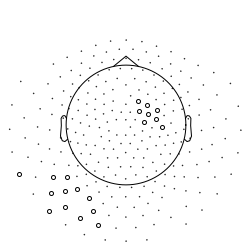

In [107]:
picks_theta = np.argsort(avg_itc._data[:, (avg_itc.freqs > 7) & (avg_itc.freqs < 8.5)][..., (avg_itc.times > 0.2) & (avg_itc.times < 0.4)].mean(-1).mean(-1))[::-1][:20]
picks_delta = np.argsort(avg_itc._data[:, (avg_itc.freqs > 0.5) & (avg_itc.freqs < 4.5)][..., (avg_itc.times > 0.2) & (avg_itc.times < 0.4)].mean(-1).mean(-1))[::-1][:20]

f, ax = plt.subplots(1, 1)
mne.viz.plot_topomap(np.zeros((267,)), avg_itc.info, show=False, axes=ax, cmap=sns.blend_palette(['w', 'w'], as_cmap=True),
                     mask=np.asarray([c in picks_theta for c in range(267)]))
f.set_facecolor('w')

In [24]:
# for stats need theta/or delta or whatvever data for each subject 
# pop_itc = np.asarray([t[0]._data[:, (avg_itc.freqs > 5.5) & (avg_itc.freqs < 7.5)][..., (avg_itc.times > 0.1) & (avg_itc.times < 0.2)].mean(-1).mean(-1) for t in TFRs['ITC']])
# pop_itc = np.asarray([t[0]._data[:, (avg_itc.freqs > .5) & (avg_itc.freqs < 4.5)][..., (avg_itc.times > 0.2) & (avg_itc.times < 0.4)].mean(-1).mean(-1) for t in TFRs['ITC']])
pop_itc = np.asarray([t[0]._data for t in TFRs['ITC']])

In [114]:
adj, chnames = mne.channels.find_ch_adjacency(info, 'mag')
picks = mne.pick_channels(chnames, info.ch_names)
adj = adj[picks][:, picks]

Reading adjacency matrix for ctf275.


In [23]:
import networkx as nx
G = nx.lattice.grid_2d_graph(3, 3)
nx.adjacency_matrix(G)

In [289]:
# forstats = pop_itc.copy()
# forstats = forstats - forstats[..., (avg_itc.times < 0) & (avg_itc.times > -0.3)].mean(-1, keepdims=True)
forstats = np.asarray(new_pop_itc).reshape(25, 267, -1)

In [290]:
adj_lattice = np.load('./adj_matrix_lattice_32x281.npy')

In [243]:
np.asarray(new_pop_itc).shape

(25, 267, 32, 281)

In [245]:
full_adj = mne.stats.combine_adjacency(adj, 32, 281)
stats = mne.stats.permutation_cluster_1samp_test(np.asarray(new_pop_itc),
                                                 adjacency=full_adj, n_permutations=500, n_jobs=6, tail=1, threshold=2.0)

Using a threshold of 1.710882
stat_fun(H1): min=-7.587471 max=6.675479
Running initial clustering
Found 5667 clusters
Permuting 499 times...


  0%|          |  : 0/499 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


In [292]:
full_adj = mne.stats.combine_adjacency(adj, adj_lattice)
stats = mne.stats.permutation_cluster_1samp_test(forstats,
                                                 adjacency=full_adj, n_permutations=500, n_jobs=6, tail=1, threshold=2.0)

stat_fun(H1): min=-7.587471 max=6.675479
Running initial clustering
Found 5161 clusters
Permuting 499 times...


  0%|          |  : 0/499 [00:00<?,       ?it/s]

KeyboardInterrupt: 

In [266]:
mask[np.unique(stats[1][clus_idx][1])][:, np.unique(stats[1][clus_idx][2])]

array([[nan, nan, nan, nan, nan, nan]])

41.0


/scratch/hugwei/49515454.dccn-l029.dccn.nl/ipykernel_28659/3566985387.py:6: RuntimeWarning: Mean of empty slice
  plt.imshow(np.nanmean(mask, 0), aspect='auto', origin='lower', vmin=0, vmax=1)


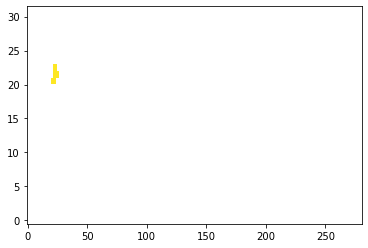

In [288]:
clus_idx = 13
mask = np.ones_like(stats[0]) * np.nan
mask[stats[1][clus_idx]] = 1.
# mask[np.unique(stats[1][clus_idx][1])][:, np.unique(stats[1][clus_idx][2])] = 1.0
print(np.nansum(mask))
plt.imshow(np.nanmean(mask, 0), aspect='auto', origin='lower', vmin=0, vmax=1)

In [54]:
from scipy.stats import ttest_1samp

In [48]:
new_pop_itc = []
for t in TFRs['ITC']:
    new_pop_itc.append(t[0].copy().apply_baseline((-0.35, 0.), mode='zscore')._data)

Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mo

In [74]:
10**(-toplot.max())

0.08330422571770371

(-0.3, 0.8)

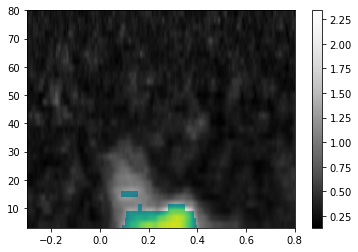

In [131]:
picks = picks_delta
toplot = -np.log10(ttest_1samp(new_pop_itc, 0).pvalue[picks].mean(0))
mask = np.ones_like(toplot) * np.nan
mask[toplot>-np.log10(0.08)] = 1.
plt.imshow(-np.log10(ttest_1samp(new_pop_itc, 0).pvalue[picks].mean(0)), aspect='auto', origin='lower', cmap='Greys_r',
          extent=[avg_itc.times[0], avg_itc.times[-1], avg_itc.freqs[0], avg_itc.freqs[-1]])
plt.colorbar()
plt.imshow(mask*-np.log10(ttest_1samp(new_pop_itc, 0).pvalue[picks].mean(0)), aspect='auto', origin='lower', vmin=0.2, vmax=2.5,
          extent=[avg_itc.times[0], avg_itc.times[-1], avg_itc.freqs[0], avg_itc.freqs[-1]])
plt.xlim([-0.3, 0.8])

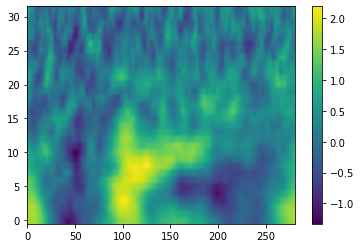

In [55]:
plt.imshow(ttest_1samp(new_pop_itc, 0).statistic[picks_theta].mean(0), aspect='auto', origin='lower')
plt.colorbar()

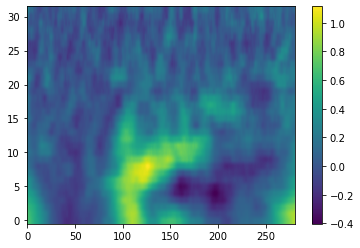

In [112]:
plt.imshow(np.mean([n for k, n in enumerate(new_pop_itc) if k!=7 and k!=10], 0)[picks_theta].mean(0), aspect='auto', origin='lower')
plt.colorbar()

###  Panel D

In [ ]:
f1 = avg_itc.plot_joint(timefreqs=((0.125, 5), (0.325, 3)), baseline=(-0.35, 0.), mode='zscore',
                   tmin=-0.3, tmax=0.8, fmin=3, fmax=15, title='ITC', cmap=cmap,
                   vmin=0.0375, vmax=3.,
                   # image_args={'mask':mask.astype(bool)},
                   topomap_args={'vmin':0., 'vmax':10.0, 'sphere':0.1, 'contours':0, 'sensors':False});

Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/viz/topomap.py:472: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home

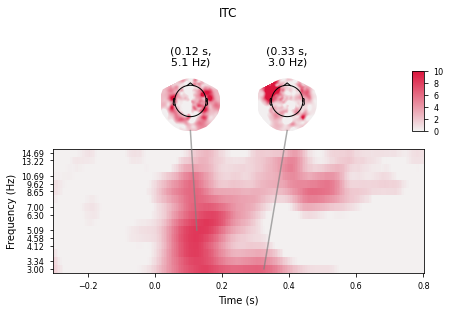

Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/viz/topomap.py:472: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home

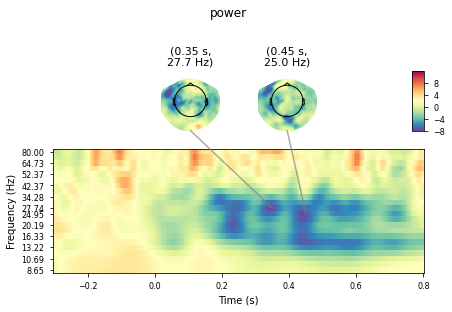

In [109]:
with plt.style.context([{'pdf.fonttype':42}, 'seaborn-paper', paper_fontsizes]):
    
    # picks = picks_delta
    # toplot = -np.log10(ttest_1samp(new_pop_itc, 0).pvalue[picks].mean(0))
    # mask = np.ones_like(toplot) * np.nan
    # mask[toplot>-np.log10(0.08)] = 1.
    # mask[np.isnan(mask)] = 0
    # mask = mne.time_frequency.AverageTFR(mne.create_info(['ave'], 200, ch_types='mag'), np.asarray([mask]), avg_itc.times, avg_itc.freqs, 1).crop(tmin=-0.3, tmax=0.8, fmin=3, fmax=15)._data[0]

    cmap = sns.light_palette('crimson', as_cmap=True)
    f1 = avg_itc.plot_joint(timefreqs=((0.125, 5), (0.325, 3)), baseline=(-0.35, 0.), mode='zscore',
                       tmin=-0.3, tmax=0.8, fmin=3, fmax=15, title='ITC', cmap=cmap,
                       vmin=0.0375, vmax=3.,
                       # image_args={'mask':mask.astype(bool)},
                       topomap_args={'vmin':0., 'vmax':10.0, 'sphere':0.1, 'contours':0, 'sensors':False});
    f1.set_figwidth(7.5/2)
    f1.savefig('../../Manuscripts/SyntaxPaper/Figures/Figure2PanelD1-paper.pdf', bbox_inches='tight', dpi=300)
    f1.savefig('../../Manuscripts/SyntaxPaper/Figures/Figure2PanelD1-paper.svg', bbox_inches='tight', dpi=300)
    
    f2 = avg_pow.plot_joint(timefreqs=((0.35, 28), (0.45, 25)), baseline=(-0.35, 0.), mode='zscore',
                       tmin=-0.3, tmax=0.8, fmin=8, fmax=80, title='power', cmap='Spectral_r',
                      topomap_args={'sphere':0.1, 'contours':0, 'vmin':-8.0, 'sensors':False});
    f2.set_figwidth(7.5/2)
    f2.savefig('../../Manuscripts/SyntaxPaper/Figures/Figure2PanelD2-paper.pdf', bbox_inches='tight', dpi=300)
    f2.savefig('../../Manuscripts/SyntaxPaper/Figures/Figure2PanelD2-paper.svg', bbox_inches='tight', dpi=300)

In [207]:
cohs = []
for x, r in tqdm(zip(Xenv, raws), total=len(raws)):
    fr, coh = coherence(resample_poly(x, 2, 1), r._data.T, axis=0, fs=fs, nfft=1024, nperseg=256)
    cohs.append(coh)
nl_coh = np.mean(cohs[:9], 0)
fr_coh = np.mean(cohs[9:], 0)

  0%|          | 0/13 [00:00<?, ?it/s]

In [130]:
fr = np.fft.rfftfreq(1024, 1/200.)

In [258]:
# Need to fix the number of channels
nl_coh = np.mean(nl_cohs, 0)
fr_coh = np.mean(fr_cohs, 0)

In [18]:
# nl_coh = np.mean([c for c in nl_cohs if c.shape[1]==269], 0)
# fr_coh = np.mean([c for c in fr_cohs if c.shape[1]==269], 0)

###  Panel C

In [121]:
stats = mne.stats.spatio_temporal_cluster_1samp_test(np.asarray([n-f for n,f in zip(nl_cohs, fr_cohs)]), adjacency=adj)

Using a threshold of 2.063899
stat_fun(H1): min=-7.779974 max=5.455000
Running initial clustering
Found 2069 clusters
Permuting 1023 times...


  0%|          |  : 0/1023 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


In [132]:
fr[stats[1][895][0]]

array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.1953125, 0.1953125,
       0.1953125, 0.1953125, 0.1953125, 0.1953125, 0.1953125, 0.1953125,
       0.1953125, 0.1953125, 0.1953125, 0.1953125, 0.1953125, 0.1953125,
       0.1953125, 0.1953125, 0.1953125, 0.1953125, 0.1953125, 0.1953125,
       0.1953125, 0.1953125, 0.1953125, 0.1953125, 0.1953125, 0.1953125,
       0.1953125, 0.1953125, 0.1953125, 0.1953125, 0.1953125, 0.1953125,
       0.1953125, 0.1953125, 0.1953125, 0.1953125, 0.1953125, 0.1953125,
       0.1953125, 0.1953125, 0.390625 , 0.390625 , 

In [133]:
stats[2][np.nonzero(stats[2]<0.05)]

array([0.00976562, 0.00097656])

/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/viz/topomap.py:472: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/viz/topomap.py:472: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/viz/topomap.py:472: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/viz/topomap.py:472: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  f

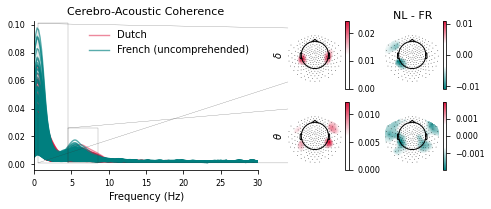

In [261]:
with plt.style.context([{'pdf.fonttype':42}, 'seaborn-paper', paper_fontsizes]):
    
    f, ax = plt.subplots(2, 3, figsize=(7.5, 7.5/3), gridspec_kw={'width_ratios':[1.66, 0.5, 0.5], 'wspace':0.25})
    ax_topo = ax[:, 1:]
    gs = ax[0,0].get_gridspec()
    ax[1, 0].remove()
    ax[0, 0].remove()
    ax_coh = f.add_subplot(gs[:, 0])
    
    topomap(nl_coh[(fr > 4.5) & (fr < 8), :].mean(0), info, ax=ax_topo[1, 0], cmap=sns.palettes.blend_palette(['w', 'w',  'crimson'], as_cmap=True), contours=0); # theta
    topomap(nl_coh[(fr > 0.5) & (fr < 4.5), :].mean(0), info, ax=ax_topo[0, 0], cmap=sns.palettes.blend_palette(['w', 'w',  'crimson'], as_cmap=True), contours=0); # delta
    topomap(nl_coh[(fr > 4.5) & (fr < 8), :].mean(0) - fr_coh[(fr > 4.5) & (fr < 8), :].mean(0), info, ax=ax_topo[1, 1],
                 cmap=sns.palettes.blend_palette(['teal', 'w', 'w',  'crimson'], as_cmap=True), contours=0);
    topomap(nl_coh[(fr > 0.5) & (fr < 4.), :].mean(0) - fr_coh[(fr > 0.5) & (fr < 4.), :].mean(0), info, ax=ax_topo[0, 1],
                 cmap=sns.palettes.blend_palette(['teal', 'w', 'w',  'crimson'], as_cmap=True), contours=0);
    # ax_topo[0, 0].set_title('Activation map', y=1.05)
    ax_topo[0, 0].set_ylabel('$\\delta$')
    ax_topo[1, 0].set_ylabel('$\\theta$')
    ax_topo[0, 1].set_title('NL - FR', y=1.05)

    l1 = ax_coh.plot(fr, nl_coh, color='crimson', alpha=0.5, label='Dutch');
    l2 = ax_coh.plot(fr, fr_coh, color='teal', alpha=0.65, label='French (uncomprehended)');
    ax_coh.legend([l1[0], l2[0]], [l1[0].get_label(), l2[0].get_label()], frameon=False)
    ax_coh.set_xlim([0, 30])
    ax_coh.set_xlabel('Frequency (Hz)')
    ax_coh.set_title('Cerebro-Acoustic Coherence')
    sns.despine(ax=ax_coh)

    rect, connectors = ax_coh.indicate_inset([4.5, 0.001, 4, 0.025], inset_ax=ax_topo[1, 0], alpha=0.8, edgecolor='0.2')
    connectors[0].set_visible(True)
    connectors[1].set_visible(True)
    connectors[2].set_visible(False)
    connectors[3].set_visible(False)
    rect, connectors = ax_coh.indicate_inset([0.5, 0.001, 4, 0.1], inset_ax=ax_topo[0, 0], alpha=0.8, edgecolor='0.2', aa=True)
    connectors[0].set_visible(True)
    connectors[1].set_visible(True)
    connectors[2].set_visible(False)
    connectors[3].set_visible(False)

    f.savefig('../../Manuscripts/SyntaxPaper/Figures/Figure2PanelC-paper.pdf', bbox_inches='tight', dpi=300)
    f.savefig('../../Manuscripts/SyntaxPaper/Figures/Figure2PanelC-paper.svg', bbox_inches='tight', dpi=300)

###  Panel A

In [93]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from scipy.stats import ttest_1samp
from mne.stats import fdr_correction

In [75]:
data = np.load('all_psds.npz', allow_pickle=True)
Pxx = {}
for k in data.keys():
    Pxx[k] = data[k].item()
data.close()

In [91]:
freqs = np.fft.rfftfreq(1024, 1/200)

And removing sub002
No peak detected in subject sub011
No peak detected in subject sub018
No peak detected in subject sub025
No peak detected in subject sub032
No peak detected in subject sub017
Using a threshold of 2.093024
stat_fun(H1): min=-1.694555 max=4.728527
Running initial clustering
Found 3 clusters
Permuting 1023 times...


  0%|          |  : 0/1023 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
0.0576171875


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/viz/topomap.py:472: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay


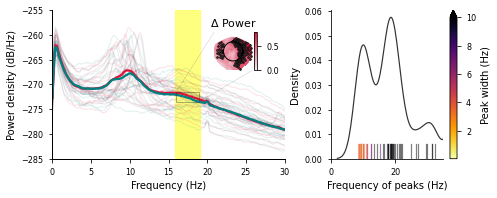

In [100]:
with plt.style.context([{'pdf.fonttype':42}, 'seaborn-paper', paper_fontsizes]):

    f, ax_array = plt.subplots(1, 2, figsize=(7.5, 7.5/3), gridspec_kw={'width_ratios':[1.66, 1,], 'wspace':0.25})
    ax = ax_array[0]
    avg_power = {'dutch': [], 'french': []}
    dutch_psd , french_psd = [], []
    for subj, subj_power in Pxx.items():
        # Test if the spectrum is well behaved
        mdl = fooof.FOOOF(peak_width_limits=(0.3, 12), peak_threshold=1.75)
        mdl.fit(freqs, subj_power['dutch'][47], [1.5, 60.])
        if mdl.get_results().peak_params.size == 0: # NO PEAKS!
            print(f'No peak detected in subject {subj}')
            #Pxx.pop(subj)
            continue
        mdl.fit(freqs, subj_power['dutch'][12], [1.5, 60.])
        if mdl.get_results().peak_params.size == 0: # NO PEAKS!
            print(f'No peak detected in subject {subj}')
            #Pxx.pop(subj)
            continue
        # And of course, remove sub-002!!!
        if subj == 'sub002' or subj == 'sub025' or subj=='sub032':
            print('And removing sub002')
            continue

        dutch_psd.append(subj_power['dutch'])
        french_psd.append(subj_power['french'])
        p = subj_power['dutch'].mean(0) # mean across channels
        p = 10*np.log10(p)
        ax.plot(freqs, p, alpha=0.1, color='crimson', lw=1.2)
        avg_power['dutch'].append(p)

        p = subj_power['french'].mean(0) # mean across channels
        p = 10*np.log10(p)
        ax.plot(freqs, p, alpha=0.1, color='teal', lw=1.2)
        avg_power['french'].append(p)

    # Plot average 
    ax.plot(freqs, np.mean(avg_power['dutch'], 0), color='crimson', lw=2.3)
    ax.plot(freqs, np.mean(avg_power['french'], 0), color='teal', lw=2.3)

    ax.set_xlim([0, 30])
    ax.set_ylim([-285, -255])
    sns.despine(ax=ax)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power density (dB/Hz)')

    # Define conditions
    condition1 = np.asarray(avg_power['dutch'])
    condition2 = np.asarray(avg_power['french'])

    T_obs, clusters, p_values, _ = mne.stats.permutation_cluster_1samp_test(condition1 - condition2, tail=0, t_power=2)
    H1, pvals_corrected = fdr_correction(ttest_1samp(condition1 - condition2, 0.0, axis=0).pvalue[:256]) # until 50Hz
    # Find cluster bondaries:
    nnz = np.nonzero(H1)[0]
    clus = []
    in_clus = False
    for k, nz in enumerate(nnz):
        if not in_clus:
            current_cluster = []
            current_cluster.append(nz)
            in_clus = True

        if k > 0 and nz == nnz[k-1]+1: # in cluster
            if (k < len(nnz)-1 and nz != nnz[k+1]-1) or k==len(nnz)-1: # last one
                current_cluster.append(nz)
                clus.append(current_cluster.copy())
                in_clus = False
            else:
                continue
    for cluster in clus:
        ax.axvspan(freqs[cluster[0]], freqs[cluster[1]], alpha=0.5, color='yellow')
    for pval, cluster in zip(p_values, clusters):
        if pval < 0.1:
            print(pval)
            ax.axvspan(freqs[cluster[0][0]], freqs[cluster[0][-1]], alpha=0.5, color='yellow')
            
    ax_inset = ax.inset_axes([0.65, 0.65, 0.28, 0.28])
    H1, _ = fdr_correction(ttest_1samp(np.asarray([np.log10(d)*10 for d in dutch_psd if d.shape[0]==269])[..., (freqs>16) & (freqs<19)].mean(-1) - \
                           np.asarray([np.log10(d)*10 for d in french_psd if d.shape[0]==269])[..., (freqs>16) & (freqs<19)].mean(-1), 0, alternative='greater').pvalue, 0.025)
    topomap(np.asarray([np.log10(d)*10 for d in dutch_psd if d.shape[0]==269]).mean(0)[:, (freqs>16) & (freqs<19)].mean(-1) - \
        np.asarray([np.log10(d)*10 for d in french_psd if d.shape[0]==269]).mean(0)[:, (freqs>16) & (freqs<19)].mean(-1),
        info_269, mask=H1, cmap=sns.light_palette('crimson', as_cmap=True,), contours=0, sensors=False, ax=ax_inset, colorbar=False,
           mask_params=dict(marker='o', markerfacecolor='w', markeredgecolor='k',
                linewidth=0, markersize=1.5));
    
    # More prettyifying
    ax.spines['bottom'].set_lw(1.0)
    ax.spines['left'].set_lw(1.0)
    # plt.colorbar(ax_inset.images[0], ax=ax_inset)
    ax_divider = make_axes_locatable(ax_inset)
    ax_inset.set_title('$\Delta$ Power')
    # Add an Axes to the right of the main Axes.
    cax1 = ax_divider.append_axes("right", size="7%", pad="5%")
    cb1 = f.colorbar(ax_inset.images[0], cax=cax1)
    # cax1.set_ylabel('$\Delta$ Power')
    
    ax.indicate_inset([16, -273.5, 3, 2], ax_inset, edgecolor='0.2', lw=0.8)
    
    cmap = 'inferno_r'
    sns.kdeplot(x=np.concatenate(list(results['peak'].values())), bw_method=0.2, color=[0.2]*3, lw=1.2, ax=ax_array[1])
    for p,w in zip(np.concatenate(list(results['peak'].values())), np.concatenate(list(results['width'].values()))):
        ax_array[1].axvline(p, alpha=0.5, lw=1.2, color=plt.cm.get_cmap(cmap)(norm(w)), ymax=0.1)
    ax_array[1].set_xlabel('Frequency of peaks (Hz)')
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), extend='max', label='Peak width (Hz)', ax=ax_array[1])
    sns.despine(ax=ax_array[1])
    ax_array[1].spines['bottom'].linewidth = 1.2
    ax_array[1].spines['left'].linewidth = 1.2
    ax_array[1].set_xlim([0, 35])
    
    f.savefig('../../Manuscripts/SyntaxPaper/Figures/Figure2PanelA-paper.pdf', bbox_inches='tight', dpi=300)
    f.savefig('../../Manuscripts/SyntaxPaper/Figures/Figure2PanelA-paper.svg', bbox_inches='tight', dpi=300)

###  Panel B

In [ ]:
import pandas as pd

In [23]:
import  matplotlib.colors as colors

In [24]:
norm = colors.LogNorm(vmin=0.01, vmax=10)
norm = colors.Normalize(vmin=0.01, vmax=10)

In [12]:
df = pd.read_pickle('Data/Fooof/sensor_global_fooof_results.pkl')
results = df.to_dict()

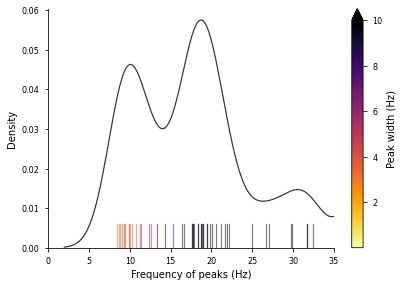

In [90]:
with plt.style.context([{'pdf.fonttype':42}, 'seaborn-paper', paper_fontsizes]):

    cmap = 'inferno_r'
    sns.kdeplot(x=np.concatenate(list(results['peak'].values())), bw_method=0.2, color=[0.2]*3, lw=1.2)
    for p,w in zip(np.concatenate(list(results['peak'].values())), np.concatenate(list(results['width'].values()))):
        plt.axvline(p, alpha=0.5, lw=1.2, color=plt.cm.get_cmap(cmap)(norm(w)), ymax=0.1)
    plt.xlabel('Frequency of peaks (Hz)')
    ax = plt.gca()
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), extend='max', label='Peak width (Hz)')
    sns.despine(ax=ax)
    ax.spines['bottom'].linewidth = 1.2
    ax.spines['left'].linewidth = 1.2
    ax.set_xlim([0, 35])